<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/model_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = "/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/data/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import Libs

In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import log_loss 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV

# Load Data

In [3]:
cont_cat_lb = pd.read_pickle(data_path + 'data_cont_cat_lb.pkl')
cont_cat_oh = pd.read_pickle(data_path + 'data_cont_cat_oh.pkl')
bin_lb_cat_lb = pd.read_pickle(data_path + 'data_bin_lb_cat_lb.pkl')
bin_oh_cat_oh = pd.read_pickle(data_path + 'data_bin_oh_cat_oh.pkl')

print('cont_cat_lb: ', cont_cat_lb.shape)
print('cont_cat_oh: ', cont_cat_oh.shape)
print('bin_lb_cat_lb: ', bin_lb_cat_lb.shape)
print('bin_oh_cat_oh: ', bin_oh_cat_oh.shape)

cont_cat_lb:  (48813, 39)
cont_cat_oh:  (48813, 133)
bin_lb_cat_lb:  (48813, 39)
bin_oh_cat_oh:  (48813, 659)


# Utile Function

In [0]:

def evaluate_test_model(X, y, verbose = True):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  gbm = lgb.LGBMClassifier(n_estimators = 1000, silent = True)
  gbm.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds = 10, verbose = 0)

  y_train_hat = gbm.predict(X_train)
  y_test_hat = gbm.predict(X_test)

  tr_acc = accuracy_score(y_train, y_train_hat)
  tr_f1 = f1_score(y_train, y_train_hat)
  tr_auc = roc_auc_score(y_train, y_train_hat)

  test_acc = accuracy_score(y_test, y_test_hat)
  test_f1 = f1_score(y_test, y_test_hat)
  test_auc = roc_auc_score(y_test, y_test_hat)
  if verbose:
    print('------train-----------')
    print('accuracy_score: ', tr_acc)
    print('f1_score: ', tr_f1)
    print('roc_auc_score: ', tr_auc)
    print('------test-------------')
    print('accuracy_score: ', test_acc)
    print('f1_score: ', test_f1)
    print('roc_auc_score: ', test_auc)
  return [test_acc, test_f1, test_auc]

# Test data encoding

## Continuous Feature Vs Binnig

### Contiuous Featrue

In [56]:
data = cont_cat_lb
X, y = data.drop(columns = 'target'), data['target']
evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8889126712328768
f1_score:  0.7458551941238196
roc_auc_score:  0.8188570477903212
------test-------------
accuracy_score:  0.8732385622943696
f1_score:  0.7130410342889264
roc_auc_score:  0.7972260517006872


(0.8732385622943696, 0.7130410342889264, 0.7972260517006872)

### Binned Features



In [47]:
data = bin_lb_cat_lb
X, y = data.drop(columns = 'target'), data['target']
evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8801369863013698
f1_score:  0.724796405504072
roc_auc_score:  0.8056286689943598
------test-------------
accuracy_score:  0.866161772921969
f1_score:  0.6981237748529824
roc_auc_score:  0.7887243367238381


## Label encoding Vs One-hot encoding

### One-hot encoding

In [48]:
data = cont_cat_oh
X, y = data.drop(columns = 'target'), data['target']
evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8833170254403131
f1_score:  0.7321729365524987
roc_auc_score:  0.8101021552821349
------test-------------
accuracy_score:  0.8752871065863803
f1_score:  0.7194525904203324
roc_auc_score:  0.8019738286097503


### Label Encoding

In [49]:
data = cont_cat_lb
X, y = data.drop(columns = 'target'), data['target']
evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8889126712328768
f1_score:  0.7458551941238196
roc_auc_score:  0.8188570477903212
------test-------------
accuracy_score:  0.8732385622943696
f1_score:  0.7130410342889264
roc_auc_score:  0.7972260517006872


# Test reducing data dimensionality

In [98]:
data = bin_oh_cat_oh
print(data.shape)
max_pranciple_component = 100

(48813, 659)


In [99]:
result = []
for component_num in range(2, max_pranciple_component):
  pca = PCA(component_num)
  X, y = data.drop(columns = 'target'), data['target']
  projected_X = pca.fit_transform(X)
  print('Reducing data dimension to: ',  component_num)
  res = evaluate_test_model(projected_X, y, False)
  result.append(res)


Reducing data dimension to:  2
Reducing data dimension to:  3
Reducing data dimension to:  4
Reducing data dimension to:  5
Reducing data dimension to:  6
Reducing data dimension to:  7
Reducing data dimension to:  8
Reducing data dimension to:  9
Reducing data dimension to:  10
Reducing data dimension to:  11
Reducing data dimension to:  12
Reducing data dimension to:  13
Reducing data dimension to:  14
Reducing data dimension to:  15
Reducing data dimension to:  16
Reducing data dimension to:  17
Reducing data dimension to:  18
Reducing data dimension to:  19
Reducing data dimension to:  20
Reducing data dimension to:  21
Reducing data dimension to:  22
Reducing data dimension to:  23
Reducing data dimension to:  24
Reducing data dimension to:  25
Reducing data dimension to:  26
Reducing data dimension to:  27
Reducing data dimension to:  28
Reducing data dimension to:  29
Reducing data dimension to:  30
Reducing data dimension to:  31
Reducing data dimension to:  32
Reducing data di

In [0]:
result = np.array(result)

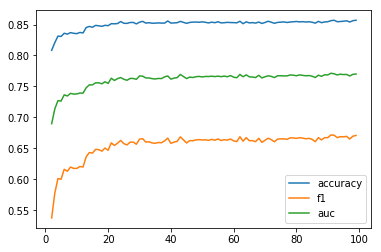

In [101]:
acc = result[:, 0]
f1 = result[:, 1]
auc = result[:, 2]
x = np.arange(2, max_pranciple_component)
plt.plot(x, acc, label = 'accuracy')
plt.plot(x, f1, label = 'f1')
plt.plot(x, auc, label = 'auc')
plt.legend()
plt.show()

In [106]:
result[90]

array([0.85691229, 0.67123092, 0.77042987])

# Feature Selection

In [0]:
data = cont_cat_lb
X, y = data.drop(columns = 'target'), data['target']

## Determine the optimal number of features

In [13]:
features_number = np.arange(1, data.shape[1])            
high_score = 0
feature_number = 0           
score_list =[]
for n in range(len(features_number)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    model = lgb.LGBMClassifier(n_estimators = 200, silent = True)
    #gbm.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds = 10, verbose = 0)
    rfe = RFE(model, features_number[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        feature_number = features_number[n]

print("Optimum number of features: %d" %feature_number)
print("Score with %d features: %f" % (feature_number, high_score))

Optimum number of features: 26
Score with 26 features: 0.874624


## Recursive Feature Elimination

In [16]:
cols = list(X.columns)
model =lgb.LGBMClassifier(n_estimators = 200, silent = True)
rfe = RFE(model, feature_number)             
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp == True].index
print(selected_features_rfe)

Index(['age', 'workclass', 'final_weight', 'education_duration',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'com_workclass', 'com_marital_status', 'com_native_country',
       'age final_weight', 'age education_duration', 'age hours_per_week',
       'age capital_gain', 'age capital_loss',
       'final_weight education_duration', 'final_weight hours_per_week',
       'final_weight capital_loss', 'education_duration hours_per_week',
       'education_duration capital_gain'],
      dtype='object')


In [0]:
selected_features = ['age', 'workclass', 'final_weight', 'education_duration',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'com_workclass', 'com_marital_status', 'com_native_country',
       'age final_weight', 'age education_duration', 'age hours_per_week',
       'age capital_gain', 'age capital_loss',
       'final_weight education_duration', 'final_weight hours_per_week',
       'final_weight capital_loss', 'education_duration hours_per_week',
       'education_duration capital_gain']

# Model Defintion

In [0]:
data = cont_cat_lb#[selected_features + ['target']]
X, y = data.drop(columns = 'target'), data['target']

In [57]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer

def objective(params):
  params = {
      'learning_rate': '{:.3f}'.format(params['learning_rate']),
      'num_leaves': int(params['num_leaves']),
      'min_data_in_leaf': int(params['min_data_in_leaf']),
      'max_depth': int(params['max_depth']),
      'bagging_fraction': '{:.3f}'.format(params['bagging_fraction']),
      'feature_fraction':'{:.3f}'.format(params['feature_fraction']),
      #'bagging_freq': int(params['bagging_freq']),
  }
  clf = lgb.LGBMClassifier(
      n_estimators = 1000,
      **params
    )
  score = cross_val_score(clf,
                          X, y, 
                          scoring = make_scorer(f1_score), 
                          cv = StratifiedKFold(n_splits = 5)
                          ).mean()
  print("F1-score {:.3f} params {}".format(score, params))
  return score

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'num_leaves': hp.quniform('num_leaves', 8, 512, 2),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 20, 500, 5),
    'max_depth': hp.quniform('max_depth', 2, 16, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 1),
    #'bagging_freq': hp.quniform('bagging_freq', 0, 30, 1),
}

best = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 20)

F1-score 0.704 params {'learning_rate': '0.055', 'num_leaves': 388, 'min_data_in_leaf': 450, 'max_depth': 13, 'bagging_fraction': '0.540', 'feature_fraction': '0.383'}
F1-score 0.709 params {'learning_rate': '0.048', 'num_leaves': 230, 'min_data_in_leaf': 430, 'max_depth': 5, 'bagging_fraction': '0.906', 'feature_fraction': '0.442'}
F1-score 0.707 params {'learning_rate': '0.081', 'num_leaves': 114, 'min_data_in_leaf': 465, 'max_depth': 8, 'bagging_fraction': '0.701', 'feature_fraction': '0.272'}
F1-score 0.703 params {'learning_rate': '0.152', 'num_leaves': 478, 'min_data_in_leaf': 395, 'max_depth': 6, 'bagging_fraction': '0.464', 'feature_fraction': '0.546'}
F1-score 0.686 params {'learning_rate': '0.157', 'num_leaves': 412, 'min_data_in_leaf': 90, 'max_depth': 10, 'bagging_fraction': '0.203', 'feature_fraction': '0.495'}
F1-score 0.689 params {'learning_rate': '0.199', 'num_leaves': 80, 'min_data_in_leaf': 405, 'max_depth': 14, 'bagging_fraction': '0.147', 'feature_fraction': '0.250

In [58]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'bagging_fraction': 0.20340094116954432, 'feature_fraction': 0.49501797191226904, 'learning_rate': 0.15712271871210043, 'max_depth': 10.0, 'min_data_in_leaf': 90.0, 'num_leaves': 412.0}


# Model Training

# Model Evaluation

# Model Saving

(29287, 38)
(29287, 1)
---validation----
(9763, 38)
(9763, 1)
---test----
(9763, 38)
(9763, 1)
[1]	training's binary_logloss: 0.506058	valid_1's binary_logloss: 0.503841
Training until validation scores don't improve for 25 rounds.
[2]	training's binary_logloss: 0.473764	valid_1's binary_logloss: 0.472134
[3]	training's binary_logloss: 0.448152	valid_1's binary_logloss: 0.447067
[4]	training's binary_logloss: 0.427019	valid_1's binary_logloss: 0.42623
[5]	training's binary_logloss: 0.409529	valid_1's binary_logloss: 0.408912
[6]	training's binary_logloss: 0.394533	valid_1's binary_logloss: 0.394282
[7]	training's binary_logloss: 0.381078	valid_1's binary_logloss: 0.381035
[8]	training's binary_logloss: 0.370002	valid_1's binary_logloss: 0.369941
[9]	training's binary_logloss: 0.360231	valid_1's binary_logloss: 0.360263
[10]	training's binary_logloss: 0.351313	valid_1's binary_logloss: 0.35154
[11]	training's binary_logloss: 0.34392	valid_1's binary_logloss: 0.344302
[12]	training's bin

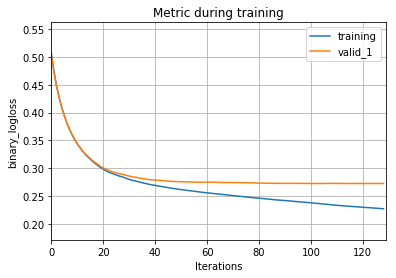

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print('---validation----')
print(X_val.shape)
print(y_val.shape)
print('---test----')
print(X_test.shape)
print(y_test.shape)
d_train = lgb.Dataset(X_train, y_train)
d_val = lgb.Dataset(X_val, y_val)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}
n_estimator = 2000
evals_result = {}
gbm = lgb.train(params, 
                   d_train, 
                   n_estimator, 
                   valid_sets = [d_train, d_val], 
                   evals_result = evals_result,
                   verbose_eval = 1, 
                   early_stopping_rounds = 25)
ax = lgb.plot_metric(evals_result)
plt.show()

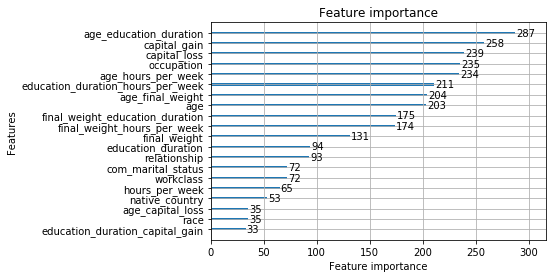

In [17]:
ax = lgb.plot_importance(gbm, max_num_features = 20)
plt.show()

In [18]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
print('------train-----------')
y_train_hat = gbm.predict(X_train)
print(accuracy_score(y_train, y_train_hat.round()))
print(f1_score(y_train, y_train_hat.round()))
print(roc_auc_score(y_train, y_train_hat.round()))
print('------validation-------')
y_val_hat = gbm.predict(X_val)
print(accuracy_score(y_val, y_val_hat.round()))
print(f1_score(y_val, y_val_hat.round()))
print(roc_auc_score(y_val, y_val_hat.round()))
print('------test-------------')
y_test_hat = gbm.predict(X_test)
print(accuracy_score(y_test, y_test_hat.round()))
print(f1_score(y_test, y_test_hat.round()))
print(roc_auc_score(y_test, y_test_hat.round()))

------train-----------
0.891180387202513
0.7537665147183806
0.8248778382822437
------validation-------
0.8766772508450271
0.7176360225140713
0.802804072862423
------test-------------
0.8688927583734508
0.7132616487455197
0.8005197740112994
